In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os

In [24]:
hamida_colors = [
    "#26274F",
"#2F3163",
"#393B76",
"#424587",
"#4C509D",
"#5559AF",
"#5F63C0",
"#676CD1",
"#676CD1",
"#676CD1",
"#8086FE",
]

In [25]:
hamida_colors.reverse()

In [26]:
hamida_colors

['#8086FE',
 '#676CD1',
 '#676CD1',
 '#676CD1',
 '#5F63C0',
 '#5559AF',
 '#4C509D',
 '#424587',
 '#393B76',
 '#2F3163',
 '#26274F']

In [2]:
files = os.listdir("results_of_algos")
results = {
}
accuracy = {}
for f in files:
    path="results_of_algos/"+f
    data = pd.read_csv(path)
    results[f.split(".")[0]]=data
    accuracy[f.split(".")[0]]=data["accuracy"][0]

In [3]:
accuracy["Graph Convolutional Network"]=0.848485

In [4]:
sorted_values = sorted(accuracy.items(), key=lambda x:x[1])

In [5]:
accuracy = dict(sorted_values)

In [6]:
keys=list(accuracy.keys())
# keys.reverse()
values = list(accuracy.values())
# values.reverse()
values=[i*100 for i in values]

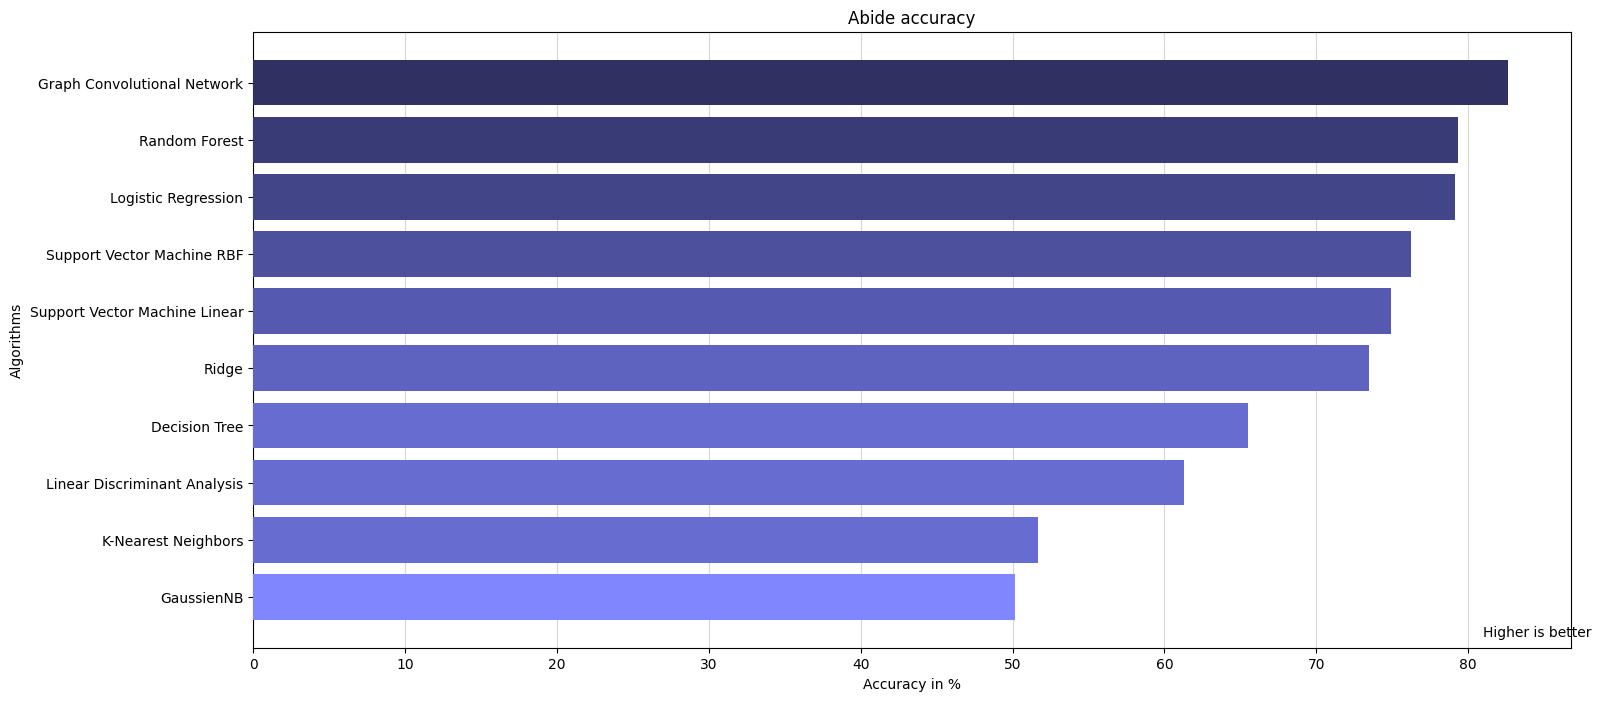

In [27]:

plt.figure(figsize=(17,8))
plt.title("Abide accuracy")
plt.grid(zorder=0,axis="x",alpha=0.5)
plt.xlabel("Accuracy in %")
plt.ylabel("Algorithms")
plt.annotate('Higher is better',xy=[81,-0.7],zorder=4)
plt.barh(keys, values, color=hamida_colors,zorder=3)
plt.show()

In [8]:
from sklearn.metrics import auc, confusion_matrix, roc_curve,confusion_matrix, ConfusionMatrixDisplay
from numpy import interp

In [9]:
def draw_cv_roc_curve(cv, out, y, thre=0, title=''):
    """
    Draw a Cross Validated ROC Curve.
    Args:
        cv: StratifiedKFold Object: (https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)
        out: Predictions
        y: Response Pandas Series
        thre: threshold
        title: title for the plot
    Example largely taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    """
    # Creating ROC Curve with Cross Validation
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    cn_matrix = np.zeros((2, 2))
    plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(121)

    i = 0
    for train, test in cv.split(out, y):
        probas_ = out.iloc[test]
        preds = [int(item) for item in (probas_.iloc[:, i].values > thre)]
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_.iloc[:, i])
        tprs.append(interp(mean_fpr, fpr, tpr))
        cn_matrix += confusion_matrix(y.iloc[test], preds)
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i + 1, roc_auc))

        i += 1
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    plt.legend(loc="lower right")

    ax2 = plt.subplot(122)
    sum_of_rows = cn_matrix.sum(axis=1)
    normalized = cn_matrix / sum_of_rows[:, np.newaxis]
    disp = ConfusionMatrixDisplay(
        normalized, display_labels=['Control', 'ASD'])
    disp.plot(ax=ax2, cmap=plt.cm.Blues)
    ax2.set_title('Confusion Matrix')

    plt.suptitle(title)
    plt.show()
    return mean_tpr,mean_fpr,mean_auc


In [10]:
import os
import pandas as pd
from sklearn.model_selection import KFold

In [11]:
import argparse
parser = argparse.ArgumentParser()

parser.add_argument('--roc', action='store_true', default=False,
                    help='Visualize ROC curve and mean confusion matrix')
parser.add_argument('--embedding', action='store_true',
                    default=False, help='Visualize the learned node embeddings')
parser.add_argument('--result_root', type=str,
                    default='./results', help='Root for the results')
parser.add_argument('--model_root', type=str,
                    default='./checkpoints', help='Root for the stored models')
parser.add_argument('--data_root', type=str,
                    default='./data', help='Root for the data')
parser.add_argument('--seed', type=int, default=13,
                    help='Random seed. To specify the test set for evaluation')
parser.add_argument('--pooling_ratio', type=float,
                    default=0.05, help='pooling ratio')
parser.add_argument('--group', type=str, default='gender',
                    help='Phenotypic attribute to group subjects on')

args = parser.parse_args([])

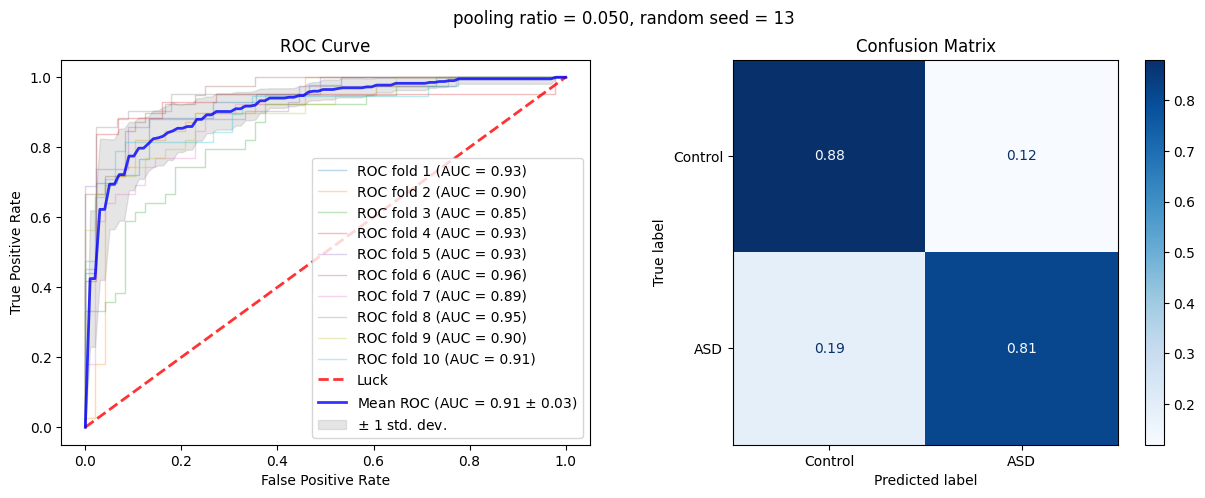

In [12]:
threshold = 0
result_path = args.result_root
assert os.path.exists(result_path), \
    'No classification result found'
file_name = [f for f in os.listdir(result_path)
                if float(f.split('_')[2]) == args.pooling_ratio and
                int(f.split('_')[-2]) == args.seed]
assert len(file_name), \
    'No result match the requirements: ' \
    'pooling ratio {:.3f}, random seed: {:d}'.format(
        args.pooling_ratio, args.seed)
file_name = file_name[0]
# load the predictions
pred = pd.read_csv(os.path.join(result_path, file_name))
# initialize k-fold
kf = KFold(n_splits=10, random_state=args.seed, shuffle=True)
# load ground truth
labels = pd.read_csv(os.path.join(
    args.data_root, 'phenotypic', 'log.csv'))['label']
# plot
mean_tpr,mean_fpr,mean_auc = draw_cv_roc_curve(kf, pred, labels, thre=threshold,
                    title='pooling ratio = {:.3f}, random seed = {:d}'.
                    format(args.pooling_ratio, args.seed))

In [13]:
results

{'Decision Tree':          fpr       tpr  roc_auc_score  accuracy
 0   0.000000  0.000000       0.578575      0.56
 1   0.153846  0.175258       0.578575      0.56
 2   0.166667  0.185567       0.578575      0.56
 3   0.230769  0.257732       0.578575      0.56
 4   0.269231  0.381443       0.578575      0.56
 5   0.294872  0.443299       0.578575      0.56
 6   0.410256  0.484536       0.578575      0.56
 7   0.435897  0.525773       0.578575      0.56
 8   0.576923  0.649485       0.578575      0.56
 9   0.589744  0.721649       0.578575      0.56
 10  0.653846  0.804124       0.578575      0.56
 11  0.666667  0.804124       0.578575      0.56
 12  0.717949  0.876289       0.578575      0.56
 13  0.871795  0.948454       0.578575      0.56
 14  1.000000  1.000000       0.578575      0.56,
 'GaussienNB':          fpr       tpr  roc_auc_score  accuracy
 0   0.000000  0.000000       0.680941       0.6
 1   0.217949  0.381443       0.680941       0.6
 2   0.217949  0.391753       0.68094

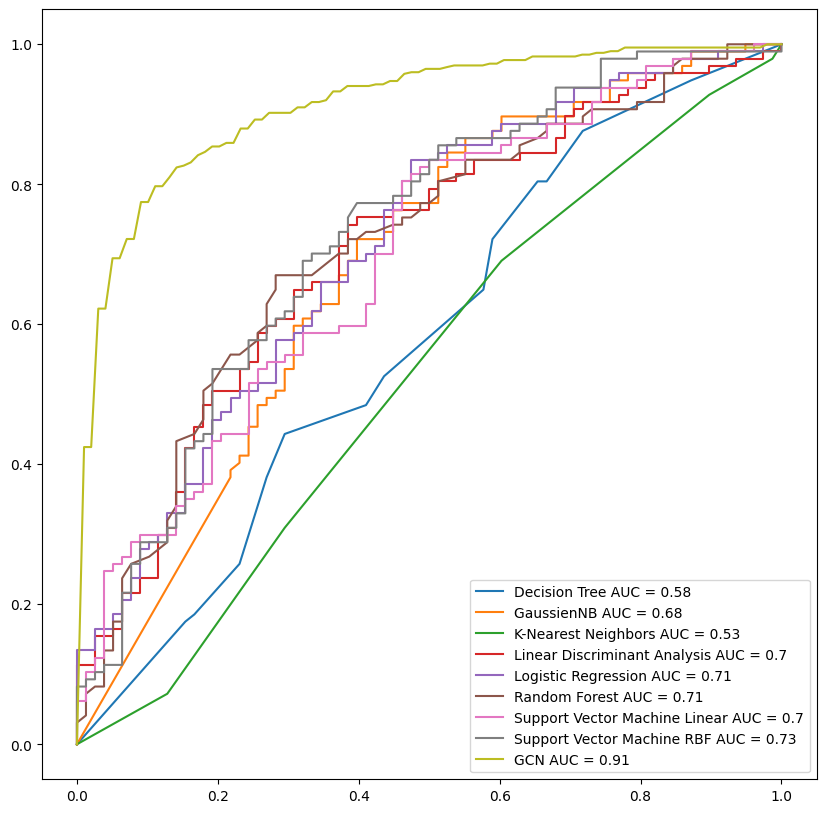

In [14]:
plt.figure(figsize=(10,10))
for key,value in results.items():
    plt.plot(value["fpr"],value["tpr"],label=f'{key} AUC = {round(value["roc_auc_score"][0],2)}')
plt.plot(mean_fpr,mean_tpr,label=f'GCN AUC = {round(mean_auc,2)}')
plt.legend(loc="lower right")
plt.show()

In [15]:
cora_acc = pd.read_csv("./cora_models_accuracy.csv")
cora_acc

,algorithm,accuracy
0,Logistic Regression,0.791513
1,K-Nearest Neighbors,0.516605
2,Support Vector Machine Linear,0.749077
3,Support Vector Machine RBF,0.761993
4,Decision Tree,0.654982
5,Random Forest,0.793358
6,GaussienNB,0.501845
7,Linear Discriminant Analysis,0.612546
8,Ridge,0.734317
9,Graph Convolutional Network,0.826000


In [16]:
cora_acc.sort_values("accuracy",inplace=True)
cora_acc

,algorithm,accuracy
6,GaussienNB,0.501845
1,K-Nearest Neighbors,0.516605
7,Linear Discriminant Analysis,0.612546
4,Decision Tree,0.654982
8,Ridge,0.734317
2,Support Vector Machine Linear,0.749077
3,Support Vector Machine RBF,0.761993
0,Logistic Regression,0.791513
5,Random Forest,0.793358
9,Graph Convolutional Network,0.826000


In [17]:
keys = cora_acc["algorithm"].values
values = cora_acc["accuracy"].values
values = [i*100 for i in values]

In [18]:
keys

array(['GaussienNB', 'K-Nearest Neighbors',
       'Linear Discriminant Analysis', 'Decision Tree', 'Ridge',
       'Support Vector Machine Linear', 'Support Vector Machine RBF',
       'Logistic Regression', 'Random Forest',
       'Graph Convolutional Network'], dtype=object)

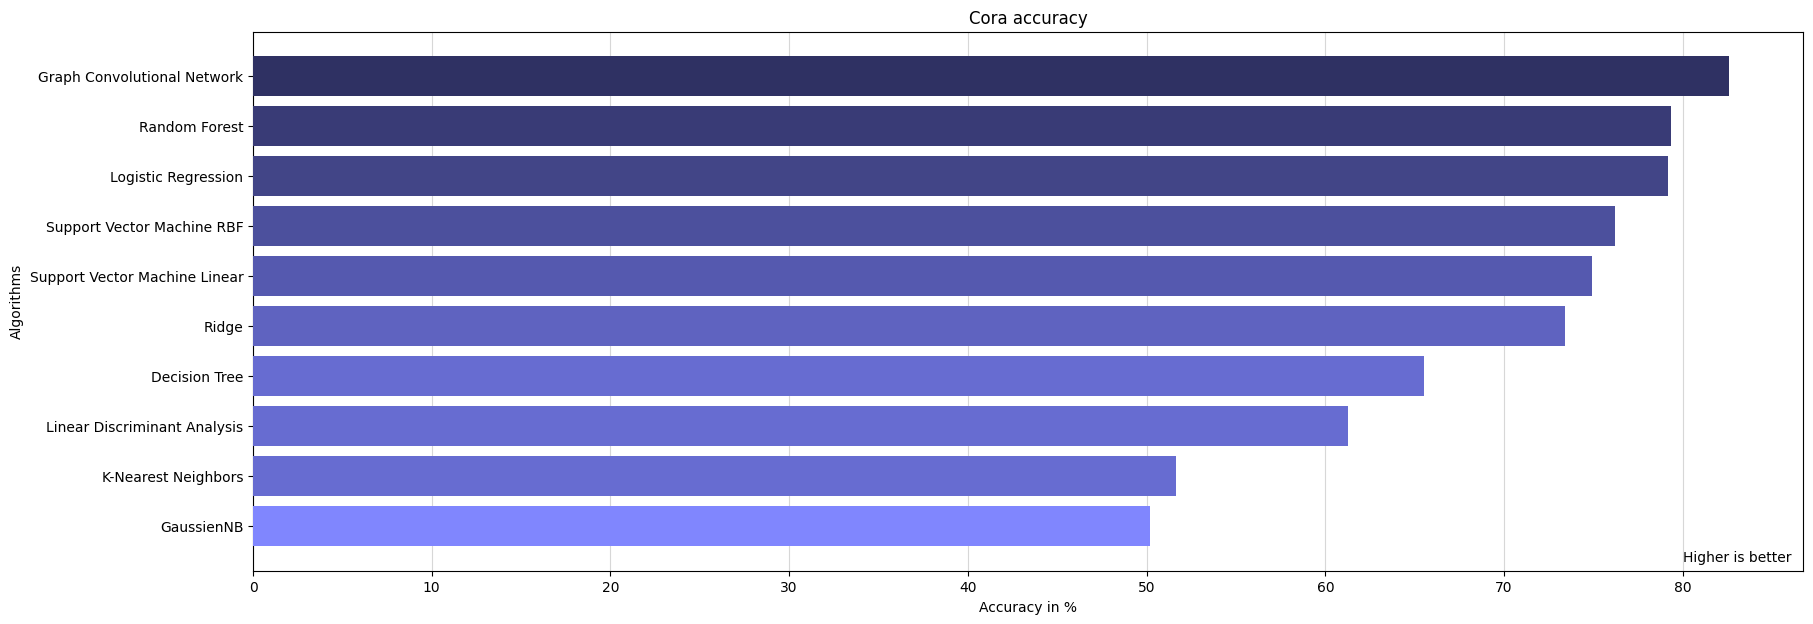

In [28]:
plt.figure(figsize=(20,7))
plt.title("Cora accuracy")
plt.grid(zorder=0,axis="x",alpha=0.5)
plt.xlabel("Accuracy in %")
plt.ylabel("Algorithms")
plt.annotate('Higher is better',xy=[80,-0.7],zorder=4)
plt.barh(keys, values, color=hamida_colors,zorder=3)
plt.show()

In [1]:
import pandas as pd

In [3]:
content = pd.read_csv("data/Further_Learned_Features/fold_1/features.txt", header=None, sep='\t')

In [8]:
content.shape

(871, 129)

In [4]:
x = content.iloc[:, :-1].values
y = content.iloc[:, -1].values

In [9]:
x.shape

(871, 128)

In [ ]:
y

In [12]:
abide_pool = pd.read_csv("data/ABIDE_downsample/ABIDE_pool_0.050_.txt", header=None, sep='\t')

In [13]:
abide_pool.shape

(871, 379)